<a href="https://colab.research.google.com/github/paoandreachv/Practica/blob/Prueba/Mina_Los_Bronces%2C_Colina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyGMTSAR Tailings Dam Interferogram: Los Bronces Mine, Colina, Chile.

blablabla

# Instalación de Google Colab

Instalaremos PyGMTSAR y los binarios requeridos de GMTSAR para que este software funcione (incluyendo SNAPHU, el cual es una herramienta complementaria usada específicamente para desenvolver fases interferométricas en imágenes de radar).


Este código se encarga de instalar las librerías y herramientas necesarias para el procesamiento InSAR en Google Colab, configurar el entorno para la visualización interactiva, y verificar que todo esté correctamente instalado.

In [141]:
# Importaremos las librerías necesarias y se verifica si el código se está
# ejecutando en Google Colab.

import platform, sys, os

if 'google.colab' in sys.modules:
# Instalación de la librería PyGMTSAR
  !{sys.executable} -m pip install -q pygmtsar
  # Instalación de dependencias binarias
  import importlib.resources as resources
  with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
      !sh {google_colab_script_filename}
  # Vamos a permitir la visualización interactiva de datos
  from google.colab import output
  output.enable_custom_widget_manager()
  # Se inicializa un espacio de memoria (buffer) que simula una pantalla, permitiendo realizar operaciones gráficas 3D
  import xvfbwrapper
  display = xvfbwrapper.Xvfb(width=800, height=600)
  display.start()

# Configuramos la variable de entorno PATH para que incluya la ruta de instalación de GMTSAR
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# Se imprime la versión de PyGMTSAR que se ha instalado.
from pygmtsar import __version__
__version__


'2024.8.30.post5'

# Cargar y configurar módulos de Python

In [142]:
# Se utiliza para trabajar con datos multidimensionales, como los datos de SAR.
import xarray as xr

# Permite trabajar con matrices y operaciones numéricas.
import numpy as np

# Se utiliza para manipular y analizar datos tabulares.
import pandas as pd

# Se utiliza para trabajar datos geoespaciales.
import geopandas as gpd

# Se usa comúnmente para almacenar y transferir datos.
import json

# Dask es ideal para trabajos que no caben en la memoria de un solo equipo.
from dask.distributed import Client

# Procesa grandes conjuntos de datos
import dask

Esta parte del código se encarga de importar y configurar las librerías necesarias para la visualización de los datos. Se divide en dos partes importantes:

- Módulos de gráficos


In [143]:
# Módulos de gráficos

# Importa la librería de PyVista (pv), que se usa para la
# visualización 3D interactiva.
import pyvista as pv

# Configura el tema de PyVista a "document", que generalmente
# usa un fondo blanco para las gráficas.
pv.set_plot_theme("document")

# Importa la librería Panel, que se usa para crear paneles interactivos
# y visualizaciones web.
import panel

# Habilita la comunicación entre Panel y los widgets de Jupyter.
panel.extension(comms='ipywidgets')

# Habilita el soporte para visualizaciones VTK (Visualization Toolkit)
# en Panel, lo que permite integrar PyVista.
panel.extension('vtk')

# Importa contextmanager para manejar el contexto de la configuración de Matplotlib
from contextlib import contextmanager

# Importa la librería Matplotlib (plt), que se usa para crear gráficos estáticos.

import matplotlib.pyplot as plt

## Se define una función mpl_setting y configura los parámetros de Matplotlib


# Con esto se define el administrador de contexto, el cual controla lo que ocurre
# antes y después de ejecutar un bloque de código.
@contextmanager

# La función mpl_settings es un administrador de contexto, es decir, es una funcionalidad
# que permite ejecutar un bloque de código dentro de un entorno controlado. Este entorno
# generalmente asegura que se realicen ciertas acciones antes y después de ejecutar ese bloque
# de código, como configurar algo temporalmente y luego restaurarlo al finalizar. Lo que
# generará este administrador de contexto es que permitirá cambiar temporalmente la configuración
# de Matplotlib y luego restaurarla a su estado original.

def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [144]:
# Configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [145]:
# Se importan varias clases y funciones de la librería PyGMTSAR, que se usa para el
# procesamiento de datos de interferomoetría de radar de apertura sintética (InSAR).

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles

## Escenas SLC de Sentinel-1 y parámetros de procesamiento


### Descending Orbit Configuration

In [146]:
SCENES = ['S1A_IW_SLC__1SDV_20221228T095628_20221228T095655_046530_05935C_5B6E',
          'S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_048703_05DB82_E456',
          'S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_054128_069509_FD9C',
          'S1A_IW_SLC__1SDV_20241123T095631_20241123T095658_056680_06F44D_5397',
          'S1A_IW_SLC__1SDV_20250103T100432_20250103T100458_057278_070BF6_DDD6']
ORBIT        = 'D'
SUBSWATH     = 1

In [147]:
import os

# Directorios definidos
WORKDIR = '/content/directorios_slc/raw_minalosbronces'
DATADIR = '/content/directorios_slc/data_minalosbronces'

# Crear los directorios si no existen
os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(DATADIR, exist_ok=True)

print(f"Directorios preparados:\n- {WORKDIR}\n- {DATADIR}")
POLARIZATION = 'VV'

Directorios preparados:
- /content/directorios_slc/raw_minalosbronces
- /content/directorios_slc/data_minalosbronces


In [148]:

DEM = f'{DATADIR}/demTranque.nc'

print(DEM)

/content/directorios_slc/data_minalosbronces/demTranque.nc


In [149]:
# Define una cadena de texto en formato Geo JSON que describe un área
# de interés (AOI). En este caso, el AOI se define como una línea que
# conecta dos puntos geográficos.

geojson = '''

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [[[-70.55, -33.29], [-70.83, -33.24], [-70.80, -33.07], [-70.51, -33.12]]]
  },
  "properties": {}
}
'''

AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

# Descargar y descomprimir conjuntos de datos

En esta sección nos encargaremos de obtener las imágenes Sentinel-1 necesarias para el análisis InSAR

In [150]:
# Ingresamos datos de cuenta en Alaska Satellite Facility (ASF)

asf_username = 'paao.ndra_2024'
asf_password = '@Paola685067512'

In [151]:
# Acá se crea un objeto ASF para interactuar con el repositorio ASF usando mis credenciales
asf = ASF(asf_username, asf_password)

# Descarga las escenas definidas en la lista SCENES al directorio DATADIR, pero sólo las que
# coinciden con el sub-swath especificado
print(asf.download(DATADIR, SCENES, SUBSWATH))

None


In [152]:
# Este código tiene la función de buscar y descargar las órbitas de los satélites que
# faltan para procesar las escenas Sentinel-1 que ya se han descargado.

S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


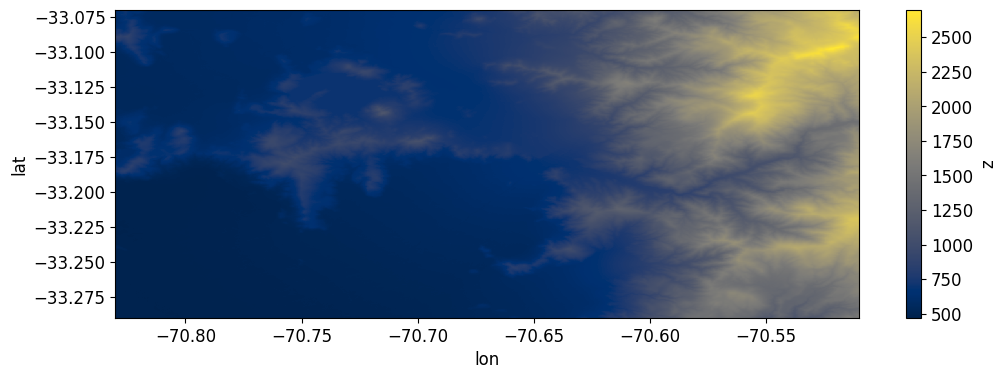

In [153]:
# Este código se encarga de descargar un DEM de Copernicus y mostrarlo como una imagen

Tiles().download_dem(AOI, filename=DEM).plot.imshow(cmap='cividis')

# Ejecutar un Clúster Local de Dask
Inicia un clúster de Dask para realizar cálculos locales y distribuidos utilizando múltiples núcleos. Esto permite procesar conjuntos de datos Sentinel-1 SLC de escala terabyte.

Un Dask es una herramienta para computación paralela que sirve para aprovechar múltiples núcleos de tu computador (local o distribuido). Esto permite manejar y procesar grandes volúmenes de datos, como imágenes de radar Sentinel-1, incluso en computadoras con recursos limitados.

In [154]:
# Inicialización de un Dask, en donde se revisa si ya hay uno en ejecución
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.scheduler:Remove client Client-f9350ec3-d2a5-11ef-822f-0242ac1c0002
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:48876; closing.
INFO:distributed.scheduler:Remove client Client-f9350ec3-d2a5-11ef-822f-0242ac1c0002
INFO:distributed.scheduler:Close client connection: Client-f9350ec3-d2a5-11ef-822f-0242ac1c0002
INFO:distributed.scheduler:Retire worker addresses (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39097'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43457'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:48862; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:41427', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1736879627.1977873')
INFO:d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39795,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:40855,Total threads: 1
Dashboard: http://127.0.0.1:36425/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:36275,


# ¿Qué es un SBAS?

SBAS significa "Small Baseline Subset" (Conjunto de Líneas Base Pequeñas). Es una técnica usada en InSAR (Interferometría de Radar de Apertura Sintética) que toma varias imágenes de radar (SAR) de un mismo lugar tomadas en diferentes momentos. Luego, selecciona imágenes que estén cerca en tiempo y que tengan pequeñas diferencias de posición entre las órbitas del satélite, para así, combinar estas imágenes para detectar y medir cambios en la superficie del terreno (como deformaciones, subsidencia o movimientos).

El objetivo de SBAS es generar mapas detallados y precisos de cómo se deforma el terreno con el tiempo.

In [155]:
# Se buscan las escenas Sentinel-1 (SLC) dentro del directorio de datos (DATADIR) que
# coincidan con el sub-swath y la polarización especificada. Esto se guarda en la variable scenes.

scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH, polarization=POLARIZATION)

In [156]:
# Se crea un objeto Stack de PyGMTSAR que representa el conjunto de escenas para el
# procesamiento SBAS.

sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2021-02-06. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2021-02-06,2021-02-06 09:55:24,D,S1B,VV,1,/content/directorios_slc/data_minalosbronces/S1B_IW_SLC__1SDV_20210206T095524_20210206T095552_02...,/content/directorios_slc/data_minalosbronces/S1B_IW_SLC__1SDV_20210206T095524_20210206T095552_02...,None,None,/content/directorios_slc/data_minalosbronces/S1B_OPER_AUX_POEORB_OPOD_20210226T111730_V20210205T...,"MULTIPOLYGON (((-67.91731 -33.01743, -67.97789 -33.00368, -68.03848 -32.98989, -68.09825 -32.976..."
2022-02-07,2022-02-07 09:56:20,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220207T095618_20220207T095645_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220207T095618_20220207T095645_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20220227T081608_V20220206T...,"MULTIPOLYGON (((-68.15442 -33.49316, -68.2091 -33.48071, -68.26165 -33.46872, -68.31539 -33.4564..."
2022-04-08,2022-04-08 09:56:20,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220408T095618_20220408T095645_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220408T095618_20220408T095645_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20220428T081656_V20220407T...,"MULTIPOLYGON (((-68.153 -33.49348, -68.2077 -33.48103, -68.26026 -33.46905, -68.31401 -33.45676,..."
2022-09-23,2022-09-23 09:56:32,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220923T095630_20220923T095657_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20220923T095630_20220923T095657_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20221013T081843_V20220922T...,"MULTIPOLYGON (((-68.20419 -33.65761, -68.2583 -33.64529, -68.3132 -33.63277, -68.36809 -33.62022..."
2022-10-29,2022-10-29 09:56:33,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20221029T095631_20221029T095658_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20221029T095631_20221029T095658_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20221118T081806_V20221028T...,"MULTIPOLYGON (((-68.20901 -33.6577, -68.26452 -33.64506, -68.31801 -33.63287, -68.37288 -33.6203..."
2022-12-28,2022-12-28 09:56:30,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20221228T095628_20221228T095655_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20221228T095628_20221228T095655_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20230117T081842_V20221227T...,"MULTIPOLYGON (((-68.20875 -33.65747, -68.26425 -33.64484, -68.31773 -33.63264, -68.3726 -33.6201..."
2023-05-26,2023-05-26 10:04:34,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_04...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_04...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20230615T080903_V20230525T...,"MULTIPOLYGON (((-70.09181 -33.03758, -70.1464 -33.02514, -70.19615 -33.01379, -70.23088 -33.0058..."
2024-06-01,2024-06-01 10:04:38,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_05...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_05...,None,None,/content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20240621T070825_V20240531T...,"MULTIPOLYGON (((-70.09044 -33.0384, -70.14504 -33.02596, -70.19479 -33.01461, -70.22952 -33.0067..."
2024-11-23,2024-11-23 09:56:33,D,S1A,VV,1,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20241123T095631_20241123T095658_05...,/content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20241123T095631_20241123T095658_05...,None,No

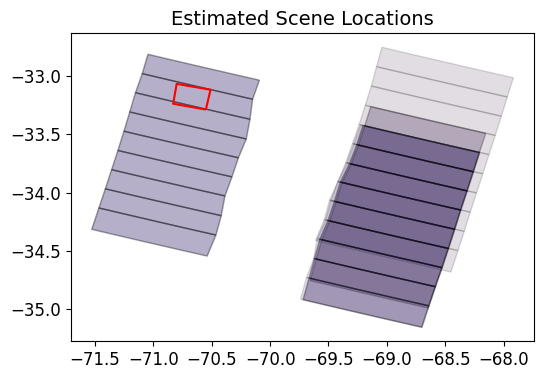

In [157]:
# Genera un gráfico que muestra la ubicación de las escenas Sentinel-1 en un mapa, utilizando el área de
# interés (AOI) como referencia.

sbas.plot_scenes(AOI=AOI)

In [158]:
print(sbas.open_data)

<bound method IO.open_data of Object Stack 10 items
                      datetime orbit mission polarization  subswath  \
date                                                                  
2021-02-06 2021-02-06 09:55:24     D     S1B           VV         1   
2022-02-07 2022-02-07 09:56:20     D     S1A           VV         1   
2022-04-08 2022-04-08 09:56:20     D     S1A           VV         1   
2022-09-23 2022-09-23 09:56:32     D     S1A           VV         1   
2022-10-29 2022-10-29 09:56:33     D     S1A           VV         1   
2022-12-28 2022-12-28 09:56:30     D     S1A           VV         1   
2023-05-26 2023-05-26 10:04:34     D     S1A           VV         1   
2024-06-01 2024-06-01 10:04:38     D     S1A           VV         1   
2024-11-23 2024-11-23 09:56:33     D     S1A           VV         1   
2025-01-03 2025-01-03 10:04:32     D     S1A           VV         1   

                                                                                               

# Reframe Scenes

Se encarga de recortar y unir escenas Sentinel-1 para optimizar el procesamiento InSAR. Es un paso opcional pero recomendable, especialmente cuando se trabaja con áreas de interés (AOI) específicas.

In [159]:
# Esta función realiza el corte y la unión (stitching) de las escenas Sentinel-1.

sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/10 [00:00<?, ?it/s]

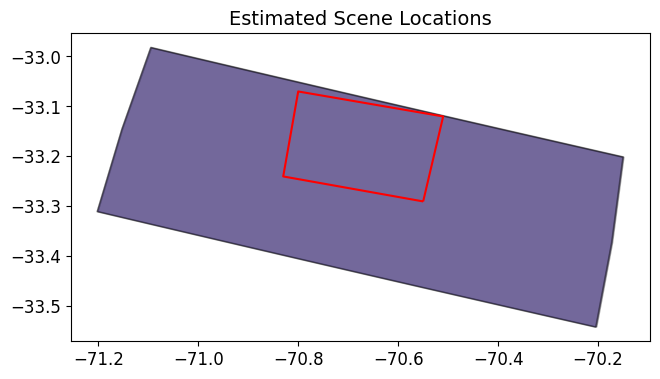

In [160]:
# Genera un gráfico que muestra las escenas recortadas y unidas en un mapa,
# utilizando el AOI como referencia.

sbas.plot_scenes(AOI=AOI)

# Cargar DEM

En el procesamiento InSAR, el Modelo Digital de Elevación (DEM) es fundamental para:

- **Corrección topográfica:** el DEM se utiliza para eliminar la influencia del relieve del terreno en las mediciones de deformación.

- **Geocodificación:** el DEM perite transformar las coordenadas de as imágenes SAR a un sistema de coordenadas geográficas.

In [161]:
# Se utilizará el área de interés (AOI) para acelerar el procesamiento
# al cargar solo la porción del DEM que se necesita.

sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-451d2579-d2a6-11ef-a3da-0242ac1c0002
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42930


In [162]:
print(sbas.open_data)

<bound method IO.open_data of Object Stack 10 items
                      datetime orbit mission polarization  subswath  \
date                                                                  
2021-02-06 2021-02-06 09:55:35     D     S1B           VV         1   
2022-02-07 2022-02-07 09:56:23     D     S1A           VV         1   
2022-04-08 2022-04-08 09:56:23     D     S1A           VV         1   
2022-09-23 2022-09-23 09:56:32     D     S1A           VV         1   
2022-10-29 2022-10-29 09:56:33     D     S1A           VV         1   
2022-12-28 2022-12-28 09:56:30     D     S1A           VV         1   
2023-05-26 2023-05-26 10:04:37     D     S1A           VV         1   
2024-06-01 2024-06-01 10:04:41     D     S1A           VV         1   
2024-11-23 2024-11-23 09:56:33     D     S1A           VV         1   
2025-01-03 2025-01-03 10:04:35     D     S1A           VV         1   

                                                                                               

In [163]:
# Este código se encarga de generar un gráfico que muestra la ubicación de las escenas
# Sentinel-1 y luego guardar ese gráfico como una imagen JPG

sbas.plot_scenes()
plt.savefig('Estimated Scene Locations.jpg')

TypeError: No numeric data to plot.

<Figure size 1200x400 with 0 Axes>